# AutoEncoder

In [2]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

# The model

In [3]:
class autoencoder(torch.nn.Module):
    """
    Simple convolutional autoencoder used as the Encoder, and Decoder portion of our model.
    """
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3,  padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=(2,2)),
            
            torch.nn.Conv2d(16, 8, 3, padding=1),  # b, 8, 3, 3
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 1, 3, padding=1),  # b, 8, 3, 3
            torch.nn.BatchNorm2d(1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=(2,2))
        )
        self.decoder = nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 16, kernel_size=(2,2), stride=2),
            
            # b, 16, 5, 5
            torch.nn.Conv2d(16, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(8, 1, kernel_size=(2,2), stride=2),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Reading in the data and extracting the mask indexs

In [597]:
all_data_files = glob("./data/*")

In [598]:
ix_tracker = np.load(all_data_files[0]).flatten()
mask_ixs = np.argwhere(ix_tracker != -1)

In [599]:
len(mask_ixs)

66794

# Cleaning the data and reading it into train and val sets.

In [600]:
def clean_data(data):
    data[data == -1] = 0
    data[143:167, 223:247][data[143:167, 223:247] == 0] = 1
    return data 
def resize_data(data):
    im = Image.fromarray(np.uint8(cm.gist_earth(data, alpha=None)*255)[:, :, :3])
    resized_data = np.array(im.resize((112, 76)).convert('L'))
    return resized_data/resized_data.max()

In [533]:
X = np.array(list(map(lambda x: resize_data(clean_data(np.load(x))), all_data_files)))

In [534]:
train_x, val_x = train_test_split(X)

In [535]:
train_x.shape

(261, 76, 112)

In [601]:
num_epochs = 1000 
batch_size = 8
w, h = 76, 112

In [537]:
def MaskLoss(base, mask):
    """
    This method generates a loss function that use only the specified indexs for calculating the loss.
    This method assumes the ixs given are from a flattened version of the images, and output. All the flattening logic for the
    inputs to the distance function are handeled here.
    """
    def distance(input, target):
         return base(
                input.flatten(start_dim=2, end_dim=3)[:,:,mask].view(input.shape[0], 1, len(mask)),
                target.flatten(start_dim=2, end_dim=3)[:,:,mask].view(target.shape[0], 1, len(mask))
            )
        
    return distance

# Setting up model datasets

In [602]:
model = autoencoder().cuda()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [540]:
train_x = torch.stack([torch.Tensor(i).view(-1, w, h) for i in train_x])
val_x = torch.stack([torch.Tensor(i).view(-1, w, h) for i in val_x])

train_dataset = TensorDataset(train_x) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset= TensorDataset(val_x) # create your datset
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Main Train loop

epoch [1/1000], loss:0.1868, val_loss:0.2264
epoch [2/1000], loss:0.1596, val_loss:0.1632
epoch [3/1000], loss:0.1351, val_loss:0.1384
epoch [4/1000], loss:0.1126, val_loss:0.1138
epoch [5/1000], loss:0.0929, val_loss:0.0921
epoch [6/1000], loss:0.0762, val_loss:0.0774
epoch [7/1000], loss:0.0625, val_loss:0.0644
epoch [8/1000], loss:0.0501, val_loss:0.0515
epoch [9/1000], loss:0.0410, val_loss:0.0425
epoch [10/1000], loss:0.0342, val_loss:0.0357
epoch [11/1000], loss:0.0290, val_loss:0.0309
epoch [12/1000], loss:0.0250, val_loss:0.0269
epoch [13/1000], loss:0.0219, val_loss:0.0234
epoch [14/1000], loss:0.0195, val_loss:0.0212
epoch [15/1000], loss:0.0176, val_loss:0.0193
epoch [16/1000], loss:0.0160, val_loss:0.0178
epoch [17/1000], loss:0.0147, val_loss:0.0161
epoch [18/1000], loss:0.0136, val_loss:0.0148
epoch [19/1000], loss:0.0126, val_loss:0.0138
epoch [20/1000], loss:0.0118, val_loss:0.0128
epoch [21/1000], loss:0.0111, val_loss:0.0119
epoch [22/1000], loss:0.0105, val_loss:0.01

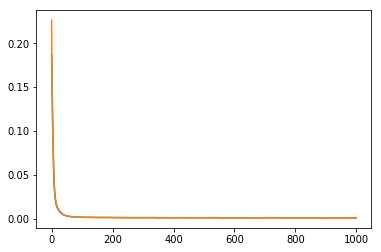

In [541]:
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    for data in train_dataloader:
        optimizer.zero_grad()
        img = data[0].cuda()
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        loss.backward()
        optimizer.step()    
    train_losses.append(loss.item())

    # Evalution
    model.eval()
    losses = []
    for val_d in val_dataloader:
        img = Variable(val_d[0]).cuda()
        out = model(img)
        loss = distance(img, out)
        losses.append(loss.item())
        
        
        
    print('epoch [{}/{}], loss:{:.4f}, val_loss:{:.4f}'.format(epoch+1, num_epochs, train_losses[-1], np.mean(losses)))
    val_losses.append(np.mean(losses))
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(val_losses)), val_losses)

# Saving model for use later

In [604]:
torch.save(model, 'autoencoder_paperv4.model')

c:\users\stone\desktop\spring2019\computationaltopology\project\proj_64\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Model Examples

In [586]:
example = val_x[0].view(-1, 1, w, h).cuda()

In [587]:
generated = model(example)

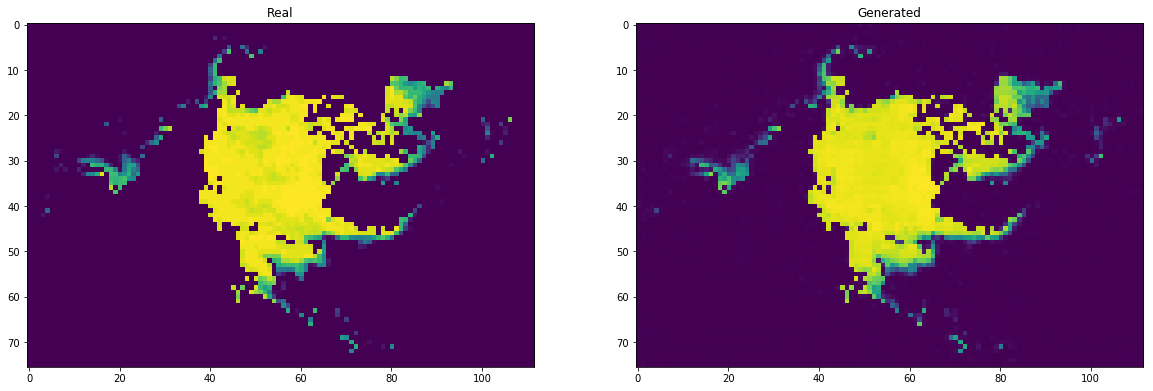

In [588]:
fig, axs = plt.subplots(1, 2, figsize=(20,20))
axs[0].set_title("Real")
axs[1].set_title("Generated")
axs[0].imshow(example.view(w,h).detach().cpu().numpy())
axs[1].imshow(generated.view(w, h).detach().cpu().numpy())